In [20]:
#All  the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten, Dropout

In [21]:
#import dataset and combine the image 
import zipfile
with zipfile.ZipFile('Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')
# Specify the folder path where the images are located
folder_path = './patch_images/'

# Use glob to get a list of image file paths
image_paths = glob.glob(folder_path + '/*.png')  # Change the extension as per your image file types
df_paths = pd.DataFrame({'Image_Path': image_paths})

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


df_paths['ImageName'] = df_paths['Image_Path'].apply(lambda x: os.path.basename(x))
data_merged_main  = pd.merge(main_data,df_paths, on='ImageName',how='inner')
data_merged_extra = pd.merge(extra_data,df_paths, on='ImageName',how='inner')

data_merged_main.head()


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,Image_Path
0,22405,1,22405.png,fibroblast,0,0,./patch_images\22405.png
1,22406,1,22406.png,fibroblast,0,0,./patch_images\22406.png
2,22407,1,22407.png,fibroblast,0,0,./patch_images\22407.png
3,22408,1,22408.png,fibroblast,0,0,./patch_images\22408.png
4,22409,1,22409.png,fibroblast,0,0,./patch_images\22409.png


In [22]:
data_merged_extra.head()

,InstanceID,patientID,ImageName,isCancerous,Image_Path
0,12681,61,12681.png,0,./patch_images\12681.png
1,12682,61,12682.png,0,./patch_images\12682.png
2,12683,61,12683.png,0,./patch_images\12683.png
3,12684,61,12684.png,0,./patch_images\12684.png
4,12685,61,12685.png,0,./patch_images\12685.png


In [23]:
#split the data into 60 20 20
train_data, test_data = train_test_split(data_merged_main , test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data , test_size=0.25, random_state=0)

# train_data, test_data = train_test_split(train_data2, test_size=0.2, random_state=0)
# train_data, val_data = train_test_split(train_data2, test_size=0.25, random_state=0)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


<h1> Model for CellType<h1>

<h3>Base Model <h3>

In [24]:
#set the parameters
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4
batch_size = 32

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model.summary()

model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2187)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               560128    
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 626,948
Trainable params: 626,948
Non-trainable params: 0
_________________________________________________________________


In [26]:
train_data['cellType'] = train_data['cellType'].astype(str)
val_data['cellType'] = val_data['cellType'].astype(str)
test_data['cellType'] = test_data['cellType'].astype(str)

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [28]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

C:\Users\Wobby\AppData\Local\Temp\ipykernel_36044\2779164914.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


In [29]:
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)

val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)

Train Loss: 0.7971768975257874
Train Accuracy: 0.6907529234886169
Validation Loss: 0.802812933921814
Validation Accuracy: 0.6907529234886169


In [30]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

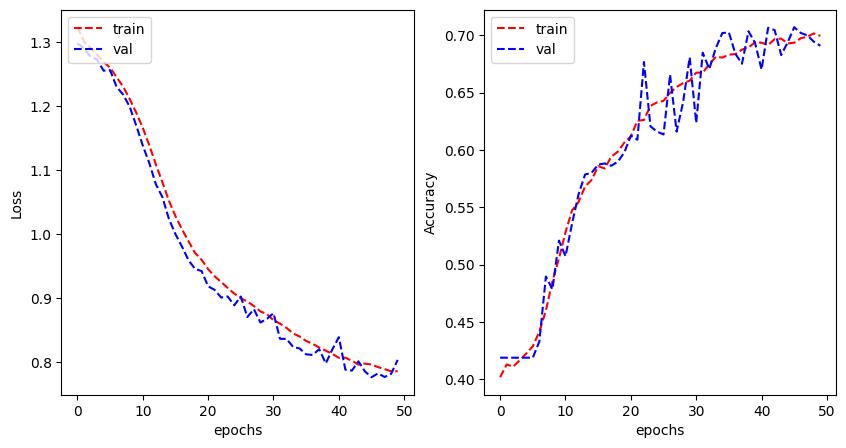

In [31]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [32]:
#test data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


batch_size =  1 #batchsize
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size
,
        class_mode='categorical')

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Found 1980 validated image filenames belonging to 4 classes.
Test Loss: 0.8339030146598816
Test Accuracy: 0.6707070469856262


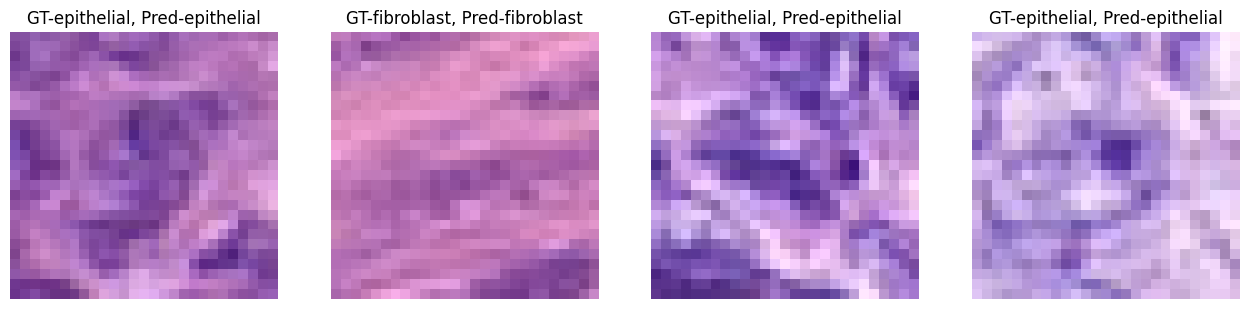

In [33]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,7))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

<H1> Incremental Tunning to get the Best Model
<h1>

In [34]:
# #running it one more time
# train_data['cellType'] = train_data['cellType'].astype(str)
# val_data['cellType'] = val_data['cellType'].astype(str)
# test_data['cellType'] = test_data['cellType'].astype(str)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define the model architecture
model_2 = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_2.summary()
#learning rate  set at 0.001
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

# early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5)


#tunning the data generation futhermore
train_dataGen_Model_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
)
val_dataGen_Model_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
)

test_dataGen_Model_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    # zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
)
batch_size = 1

train_generator_model_2 = train_dataGen_Model_2.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_model_2 = train_dataGen_Model_2.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator_model_2 = test_dataGen_Model_2.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image_Path",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

epochs = 25 #setting  to  50 for testing
history_1 = model_2.fit(
    train_generator_model_2,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=validation_generator_model_2,
    validation_steps=len(val_data) // batch_size,
    # callbacks=[early_stopping, reduce_lr]
)




Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_7 (Dense)             (None, 256)              

c:\Users\Wobby\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5937/5937 [==============================] - 34s 6ms/step - loss: 1.1002 - categorical_accuracy: 0.5515 - val_loss: 0.8872 - val_categorical_accuracy: 0.6417
Epoch 2/25
5937/5937 [==============================] - 34s 6ms/step - loss: 0.9000 - categorical_accuracy: 0.6419 - val_loss: 0.8385 - val_categorical_accuracy: 0.6614
Epoch 3/25
5937/5937 [==============================] - 33s 6ms/step - loss: 0.8567 - categorical_accuracy: 0.6616 - val_loss: 0.7585 - val_categorical_accuracy: 0.7064
Epoch 4/25
5937/5937 [==============================] - 34s 6ms/step - loss: 0.8187 - categorical_accuracy: 0.6805 - val_loss: 0.7816 - val_categorical_accuracy: 0.6978
Epoch 5/25
5937/5937 [==============================] - 34s 6ms/step - loss: 0.7981 - categorical_accuracy: 0.6877 - val_loss: 0.7179 - val_categorical_accuracy: 0.7231
Epoch 6/25
5937/5937 [==============================] - 33s 6ms/step - loss: 0.7926 - categorical_accuracy: 0.6855 - val_loss: 0.7714 - val_categorical_accuracy: 0.70

In [36]:
train_loss, train_accuracy = model_2.evaluate(train_generator_model_2, verbose=0)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)

# Evaluate the model on the validation set
val_loss, val_accuracy = model_2.evaluate(validation_generator_model_2, verbose=0)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)


test_loss, test_accuracy = model_2.evaluate(test_generator_model_2, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Train Loss: 0.6664130687713623
Train Accuracy: 0.7394306659698486
Validation Loss: 0.6406955122947693
Validation Accuracy: 0.7453259229660034
Test Loss: 0.6606633067131042
Test Accuracy: 0.7378787994384766


In [37]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


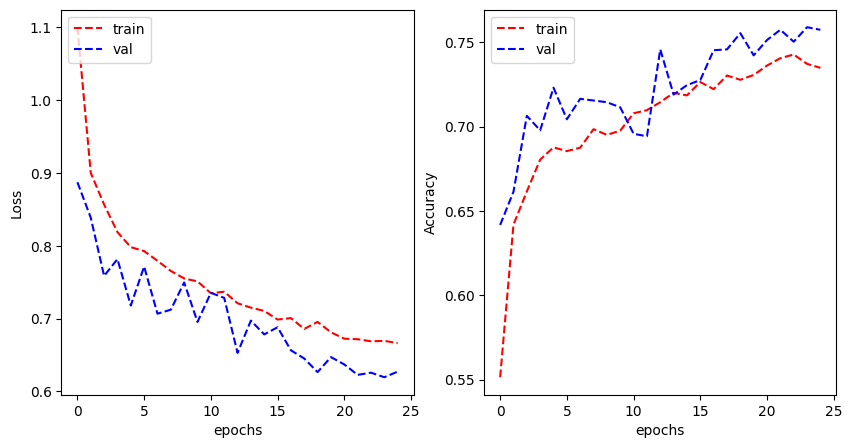

In [38]:
plot_learning_curve(history_1.history['loss'], history_1.history['val_loss'], 
                    history_1.history['categorical_accuracy'], history_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

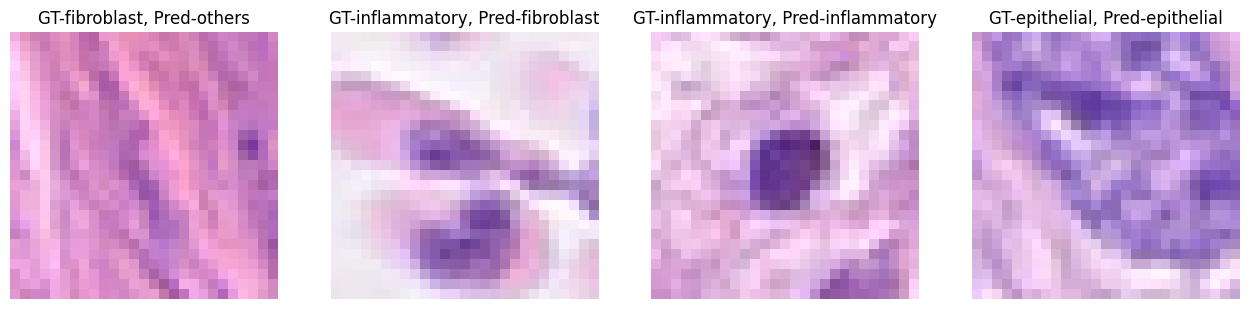

In [39]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,7))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_2.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [40]:
model.save("bestModelForCellType")

INFO:tensorflow:Assets written to: bestModelForCellType\assets


INFO:tensorflow:Assets written to: bestModelForCellType\assets


In [41]:
#Unseen data
#unseen data
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

unseenData_generator = test_datagen.flow_from_dataframe(
        dataframe=data_merged_extra,#change this line
        directory='./',
        x_col="Image_Path",
        y_col=None,#we are predicting this  
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode=None)#predicting this thats the diffrence from train data

# Load the trained model
best_model = tf.keras.models.load_model('cellType')#this line 

# Make predictions on the unseen data
predictions = best_model.predict(unseenData_generator)


# Process the predictions
predicted_classes = np.argmax(predictions, axis=1)
class_labels = train_generator.class_indices

Found 10384 validated image filenames.


OSError: Cannot parse keras metadata at path cellType\keras_metadata.pb: Received error: Error parsing message

In [ ]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
reversed_label_names = {v: k for k, v in label_names.items()}

predicted_labels = [reversed_label_names[class_index] for class_index in predicted_classes]


image_filenames = unseenData_generator.filenames


results_df = pd.DataFrame({'Image_Path': image_filenames, 'Predicted_type': predicted_classes, 'Predicted_type_name': predicted_labels})


print(results_df)

results_df.to_csv('unseen_results.csv', index=False)

                     Image_Path  Predicted_type Predicted_type_name
0      ./patch_images/12681.png               2          epithelial
1      ./patch_images/12682.png               1        inflammatory
2      ./patch_images/12683.png               1        inflammatory
3      ./patch_images/12684.png               2          epithelial
4      ./patch_images/12685.png               1        inflammatory
...                         ...             ...                 ...
10379  ./patch_images/20028.png               2          epithelial
10380  ./patch_images/20029.png               2          epithelial
10381  ./patch_images/20030.png               2          epithelial
10382  ./patch_images/20031.png               1        inflammatory
10383  ./patch_images/20032.png               0          fibroblast

[10384 rows x 3 columns]


# Model for Classification of isCancerous

In [42]:
model = Sequential()
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 2187)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               560128    
                                                                 
 dense_10 (Dense)            (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


In [43]:

tf.keras.utils.plot_model(model, show_shapes=True)
# You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [44]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image_Path",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_Path",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image_Path",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')


Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


C:\Users\Wobby\AppData\Local\Temp\ipykernel_36044\1169101688.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


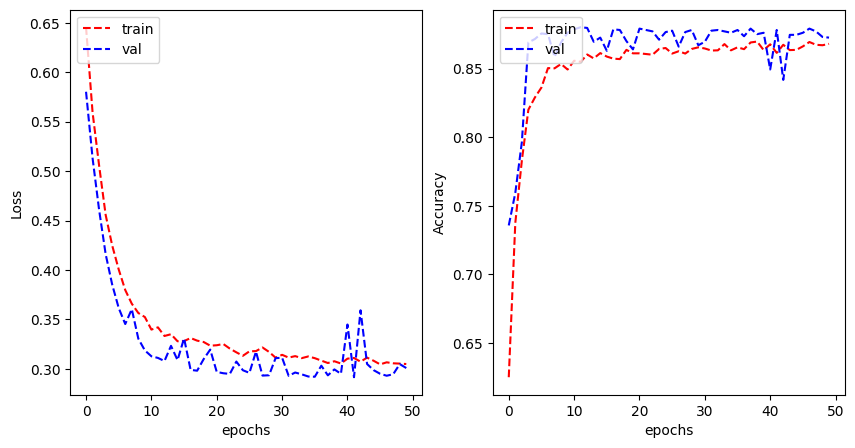

1980/1980 [==============================] - 3s 1ms/step - loss: 0.3216 - categorical_accuracy: 0.8652


[0.32155105471611023, 0.8651515245437622]

In [45]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
model.evaluate(test_generator)

## 3 Layers

C:\Users\Wobby\AppData\Local\Temp\ipykernel_36044\1652971198.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


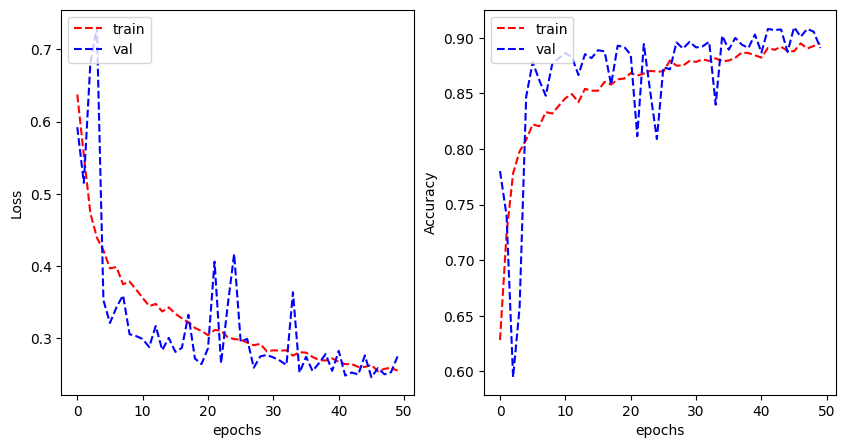

1980/1980 [==============================] - 9s 5ms/step - loss: 0.2924 - categorical_accuracy: 0.8702
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 25, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 32)        4640      
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 flatten_5 (Flatten)         (None, 28224)             0         
                                                                 
 dense_11 (Dense)            (None, 256)               7225600   
                                                                 
 dense_12 (Dense)            (None, 2)                 514       
                 

In [46]:
#Without Regularisation
model = tf.keras.Sequential([
    #First Layer
    tf.keras.layers.Conv2D(16, (3,3),1 ,activation = 'relu', input_shape=(INPUT_DIM)),
    #Second Layer   
    tf.keras.layers.Conv2D(32, (3,3),1 ,activation = 'relu'),
    #Third Layer
    tf.keras.layers.Conv2D(64, (3,3),1 ,activation = 'relu'),
    #Fourth Layer
    #tf.keras.layers.Conv2D(128, (3,3),1 ,activation = 'relu'),
    #fifth Layer
    #tf.keras.layers.Conv2D(256, (3,3),1 ,activation = 'relu'),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu')
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
model.evaluate(test_generator)
model.summary()



## 2 Layers 

C:\Users\Wobby\AppData\Local\Temp\ipykernel_36044\1439852493.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


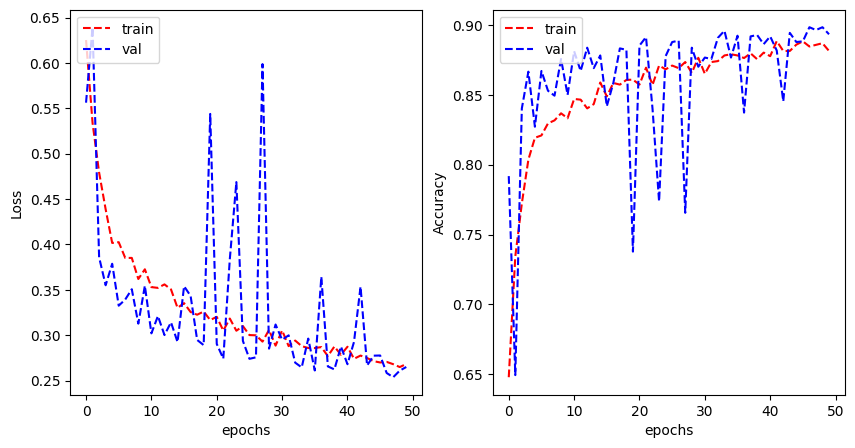

1980/1980 [==============================] - 6s 3ms/step - loss: 0.2740 - categorical_accuracy: 0.8909


[0.27402544021606445, 0.8909090757369995]

In [47]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2
model = tf.keras.Sequential([
    #First Layer
    tf.keras.layers.Conv2D(16, (3,3),1 ,activation = 'relu', input_shape=(INPUT_DIM)),
    #Second Layer   
    tf.keras.layers.Conv2D(32, (3,3),1 ,activation = 'relu'),
    #Third Layer
    #tf.keras.layers.Conv2D(64, (3,3),1 ,activation = 'relu'),
    #Fourth Layer
    #tf.keras.layers.Conv2D(128, (3,3),1 ,activation = 'relu'),
    #fifth Layer
    #tf.keras.layers.Conv2D(256, (3,3),1 ,activation = 'relu'),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu')
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
model.evaluate(test_generator)


## 4 Layers

C:\Users\Wobby\AppData\Local\Temp\ipykernel_36044\1197783209.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


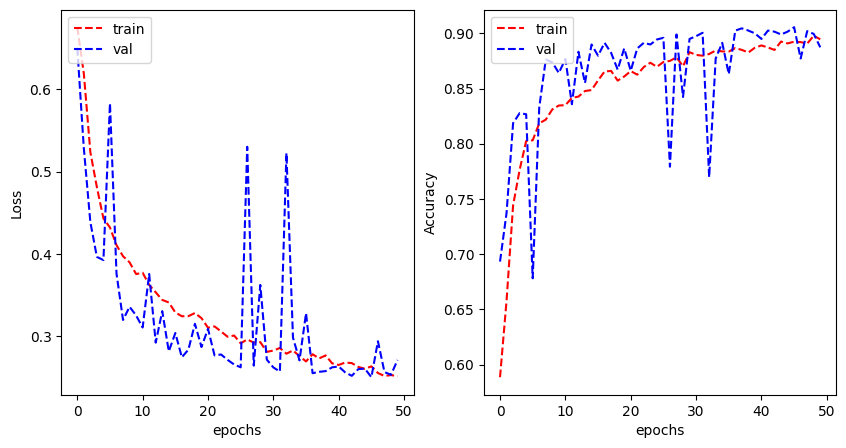

1980/1980 [==============================] - 15s 8ms/step - loss: 0.2800 - categorical_accuracy: 0.8884


[0.2800356149673462, 0.8883838653564453]

In [48]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2
model = tf.keras.Sequential([
    #First Layer
    tf.keras.layers.Conv2D(16, (3,3),1 ,activation = 'relu', input_shape=(INPUT_DIM)),
    #Second Layer   
    tf.keras.layers.Conv2D(32, (3,3),1 ,activation = 'relu'),
    #Third Layer
    tf.keras.layers.Conv2D(64, (3,3),1 ,activation = 'relu'),
    #Fourth Layer
    tf.keras.layers.Conv2D(128, (3,3),1 ,activation = 'relu'),
    #fifth Layer
    #tf.keras.layers.Conv2D(256, (3,3),1 ,activation = 'relu'),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu')
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
model.evaluate(test_generator)



## Predictions of four image cells for isCancerous/NotCancerous

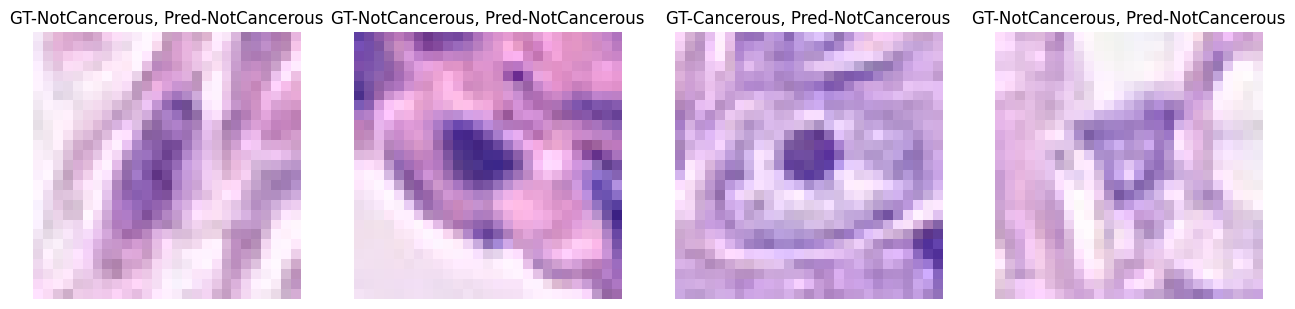

In [49]:
label_names = {'NotCancerous':0,'Cancerous':1}
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,7))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

## VGG Architecture

C:\Users\Wobby\AppData\Local\Temp\ipykernel_36044\1584962464.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)


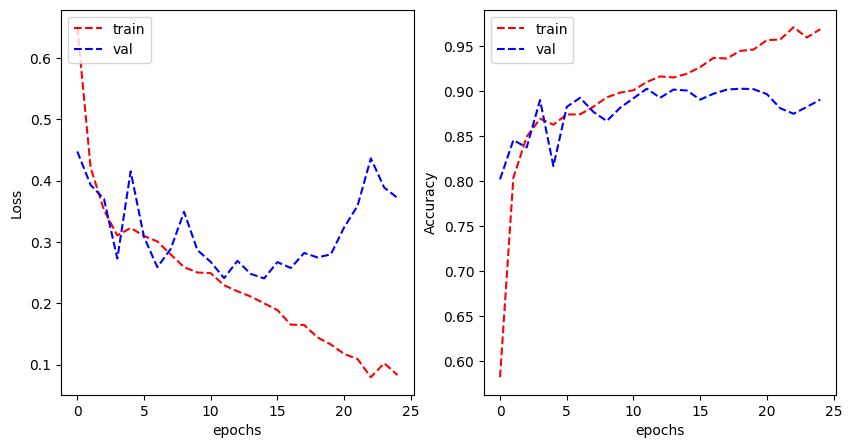

1980/1980 [==============================] - 5s 2ms/step - loss: 0.3879 - categorical_accuracy: 0.8884


[0.3879319429397583, 0.8883838653564453]

In [50]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
model_VGG_1.evaluate(test_generator)

3 Layers w/ Regularisation 
(due to overfitting in the validation set compared to the training set after epochs 10)

C:\Users\Wobby\AppData\Local\Temp\ipykernel_36044\2858388190.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)


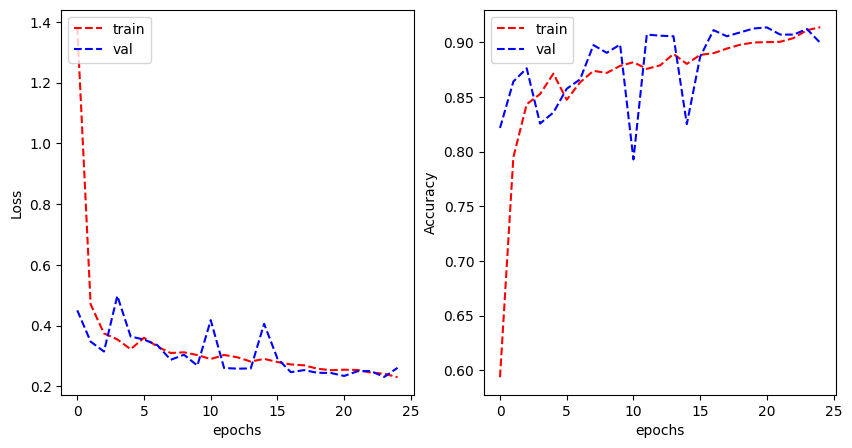

1980/1980 [==============================] - 4s 2ms/step - loss: 0.2685 - categorical_accuracy: 0.8934


[0.26847442984580994, 0.8934343457221985]

In [51]:
reg_lambda = 0.03
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
model_VGG_1.evaluate(train_generator)
model_VGG_1.evaluate(validation_generator)
model_VGG_1.evaluate(test_generator)

VGG 2 Layers w/ Regularisation

C:\Users\Wobby\AppData\Local\Temp\ipykernel_36044\1071462597.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)


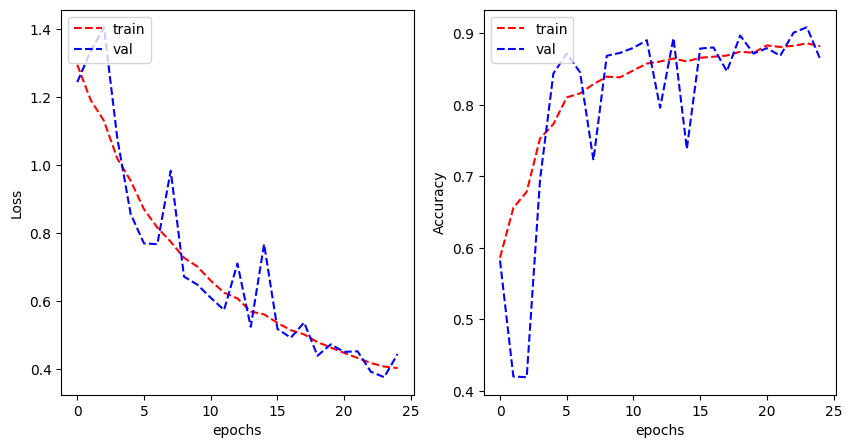

1980/1980 [==============================] - 3s 1ms/step - loss: 0.4478 - categorical_accuracy: 0.8535


[0.44784781336784363, 0.8535353541374207]

In [56]:
reg_lambda = 0.01
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    #tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    #tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    #tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
model_VGG_1.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
model_VGG_1.evaluate(test_generator)

## Predictions of 4 cells

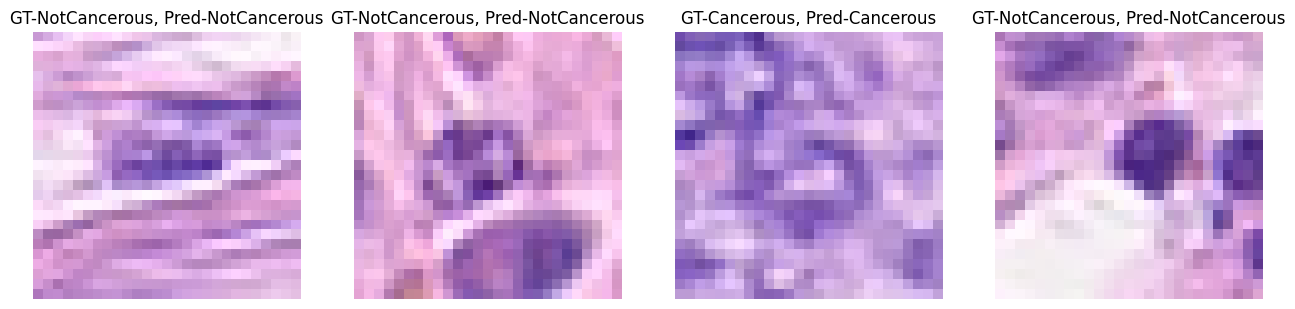

In [53]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,7))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [54]:
model_VGG_1.save("VGG_Model")

INFO:tensorflow:Assets written to: VGG_Model\assets


INFO:tensorflow:Assets written to: VGG_Model\assets
